# Deep Convolutional Generative Adversarial Network (DCGAN)

**Dataset:** Fashion MNIST Dataset

https://statstrek.com/building-creative-ai-by-putting-two-neural-networks-at-war-5aead44f79bc

In [2]:
# Import essential libraries
import numpy as np
import numpy.random as R
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, MaxPooling2D
import matplotlib.pyplot as plt

In [3]:
# Helper function to load data
def load_real_samples():
    (x_train, _), (_, _) = load_data()
    X = np.expand_dims(x_train, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

dataset = load_real_samples()
print(dataset.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


In [4]:
# Helper function to plot images
def save_plot(examples, n=10):
  plt.figure(figsize=(10,10))
  for i in range(n * n):
      plt.subplot(n, n, 1 + i)
      plt.axis('off')
      plt.imshow(examples[i].reshape(28,28), cmap='gray_r')
  filename = '/content/generated_plot.png'
  plt.show()
  plt.savefig(filename)
  plt.close()

(100, 28, 28, 1)


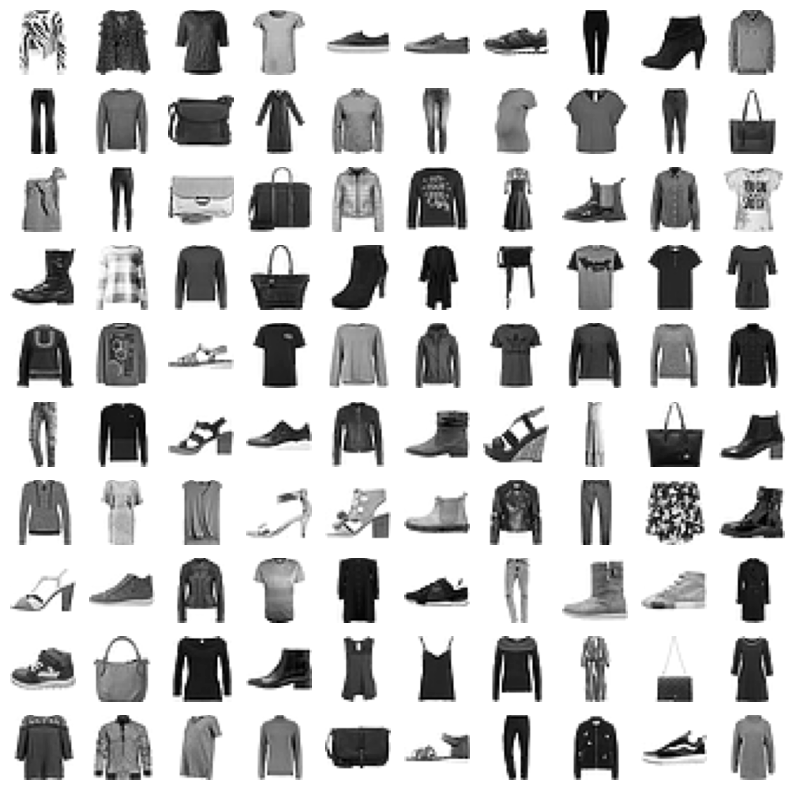

In [5]:
# Helper function to generate samples
def generate_real_samples(dataset, n_samples):
    ix = R.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

real = generate_real_samples(dataset, 100)
print(real[0].shape)
save_plot(real[0])

# Building Generator

Generator uses inverse or transpose convolutional layers to rebuild learned features.

In [6]:
latent_dim = 100

def build_generator(latent_dim):
  model = Sequential()  
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))  
  model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))    
  model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

generator = build_generator(latent_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      147584    
 ranspose)                                              

In [7]:
# Helper function to generate random input for generator
def generate_latent_vector(latent_dim, n_samples):
    x_input = R.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

4/4 [==============================] - 11s 63ms/step
(100, 28, 28, 1)


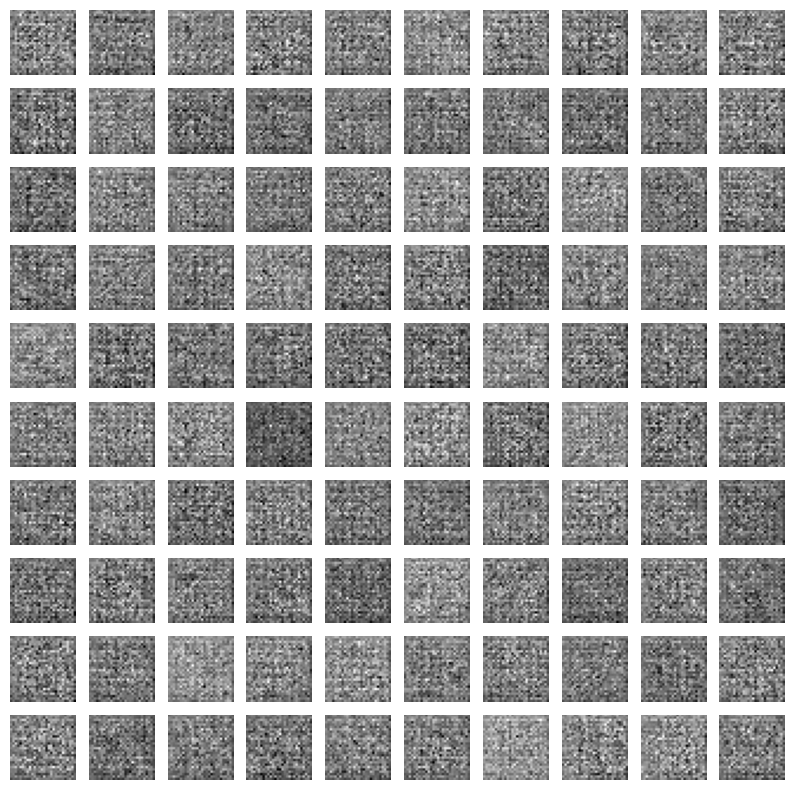

In [8]:
# Helper function to generate fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_vector(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

fake = generate_fake_samples(generator, latent_dim, 100)
print(fake[0].shape)
save_plot(fake[0])

# Building Discriminator

In [9]:
def build_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(MaxPooling2D())
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                      

# Building DCGAN

In [10]:
def build_gan(g_model, d_model):    
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan = build_gan(generator, discriminator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         934913    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 38593     
                                                                 
Total params: 973,506
Trainable params: 934,913
Non-trainable params: 38,593
_________________________________________________________________


# Training DCGAN

In [11]:
# Helper function to measure performance
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):    
    X_real, y_real = generate_real_samples(dataset, n_samples)    
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)    
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)    
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    
    save_plot(x_fake)

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 22%, fake: 98%


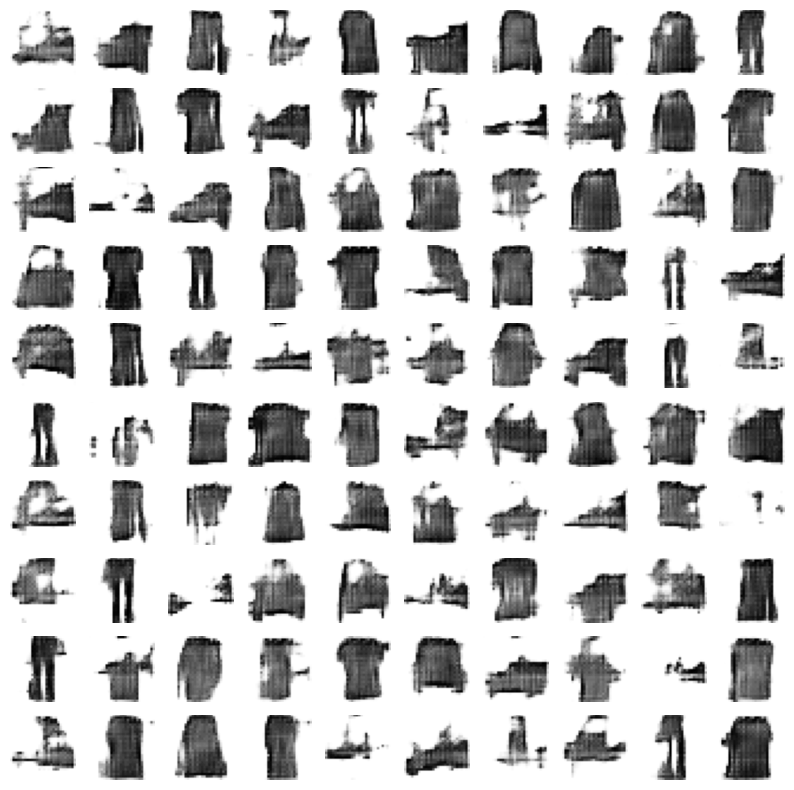

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 8%, fake: 100%


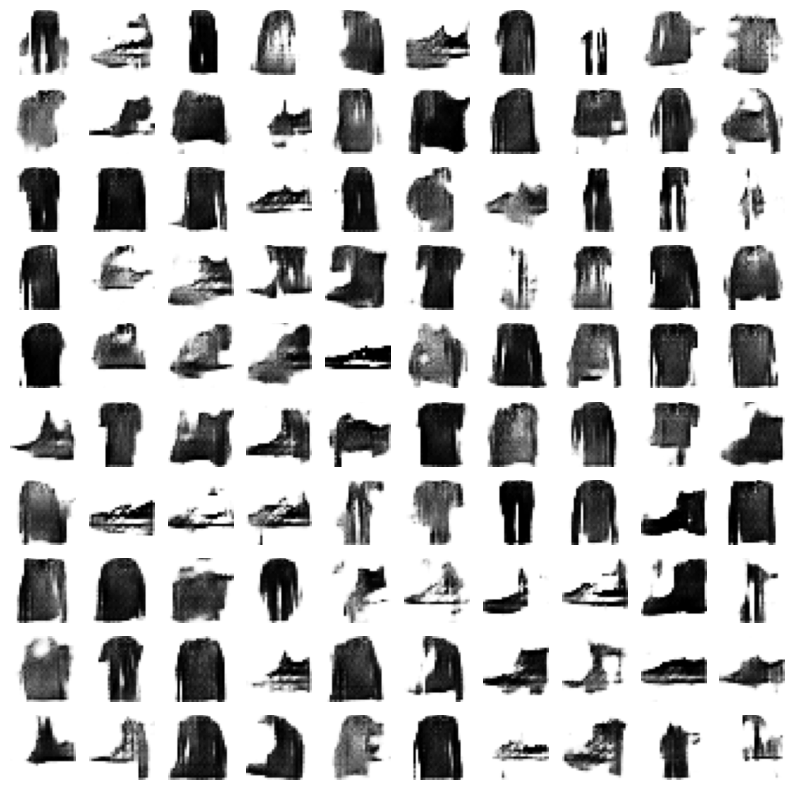

4/4 [==============================] - 0s 8ms/step
>Accuracy real: 26%, fake: 83%


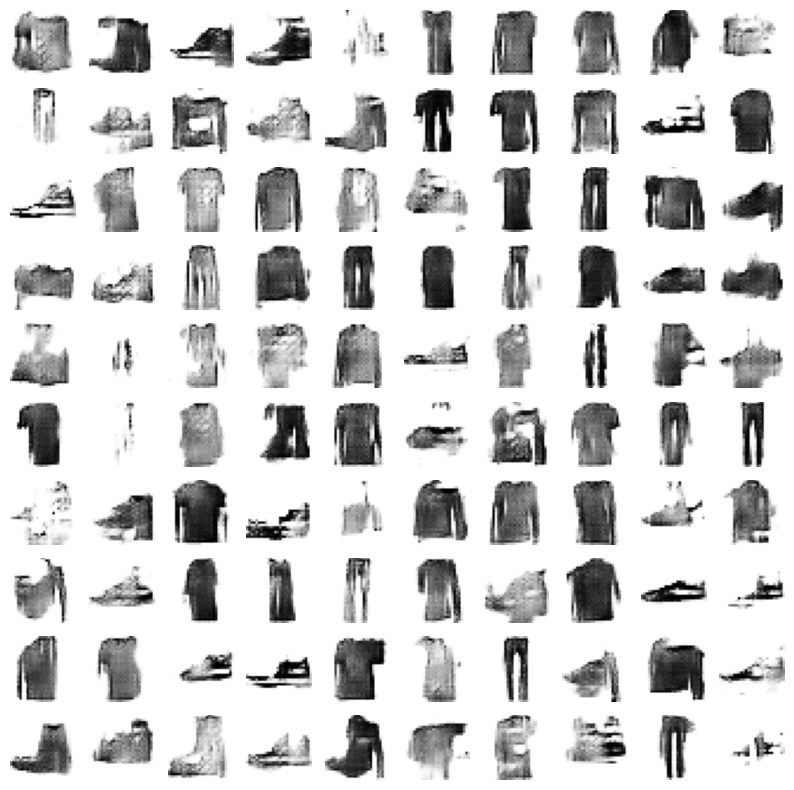

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 38%, fake: 82%


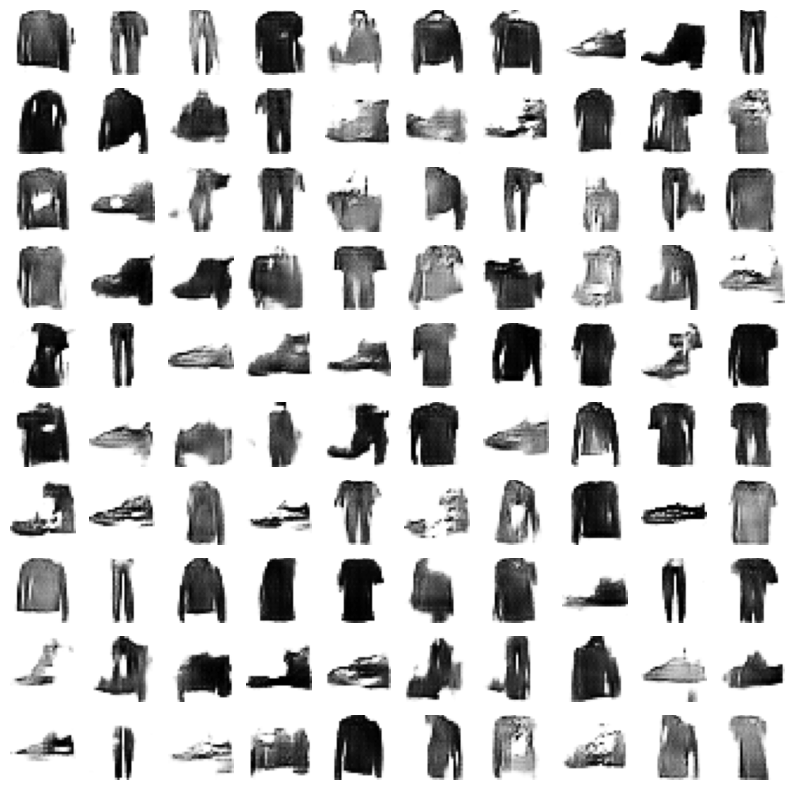

4/4 [==============================] - 0s 5ms/step
>Accuracy real: 9%, fake: 98%


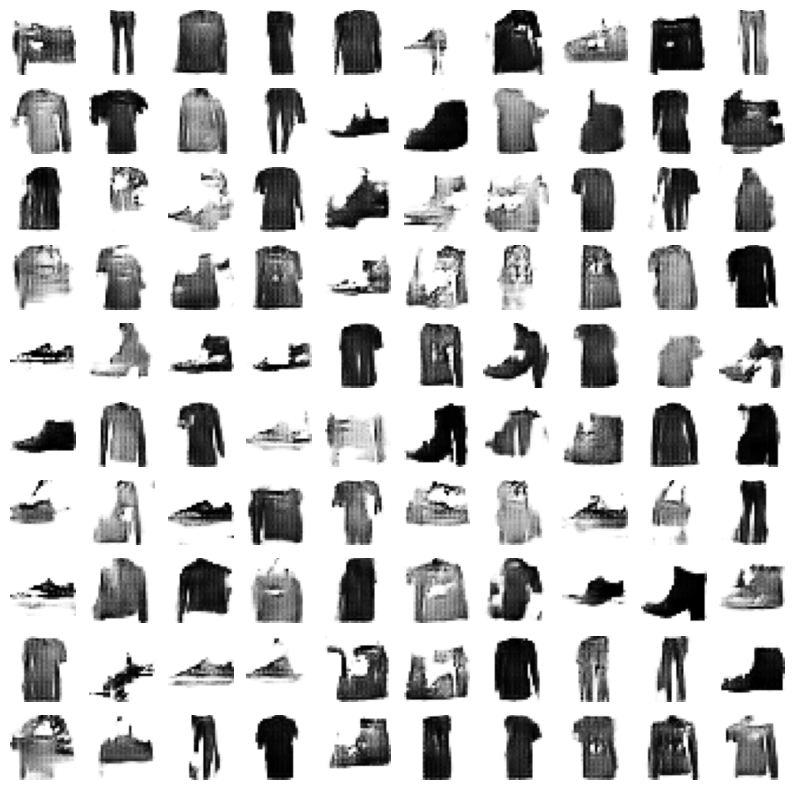

4/4 [==============================] - 0s 5ms/step
>Accuracy real: 5%, fake: 98%


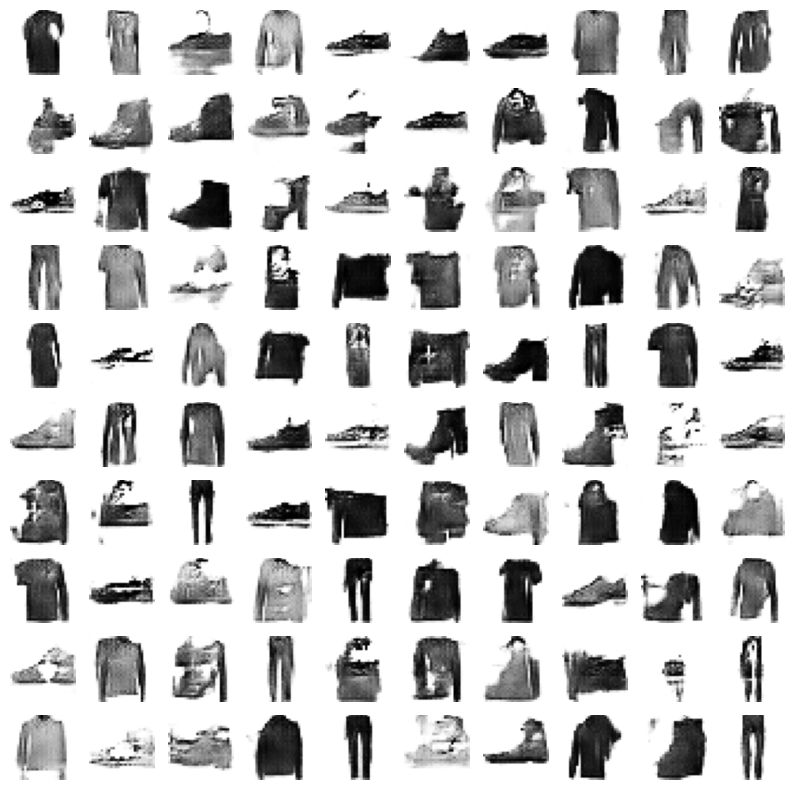

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 4%, fake: 95%


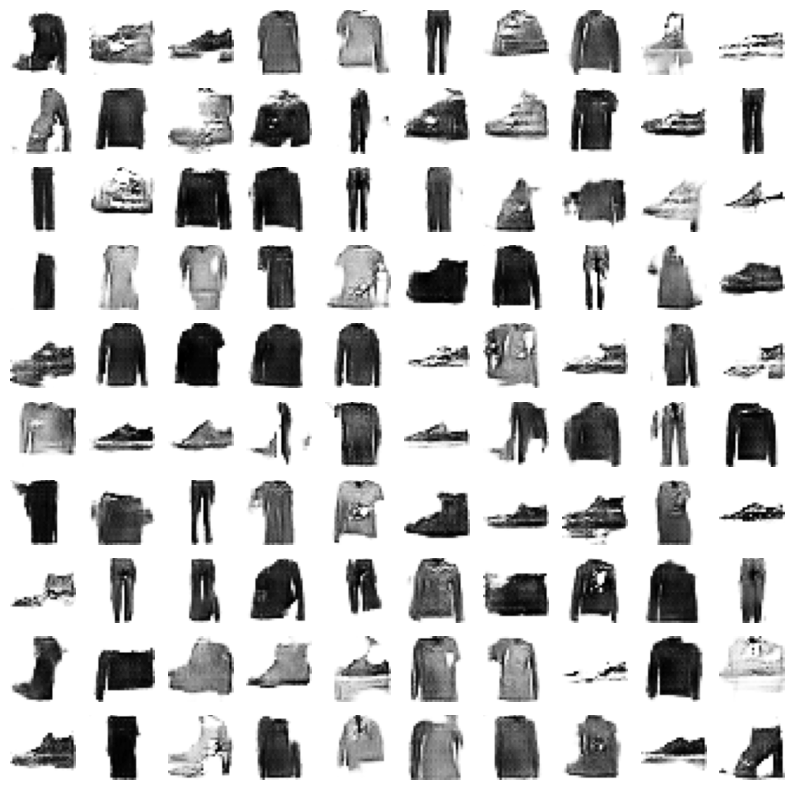

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 2%, fake: 98%


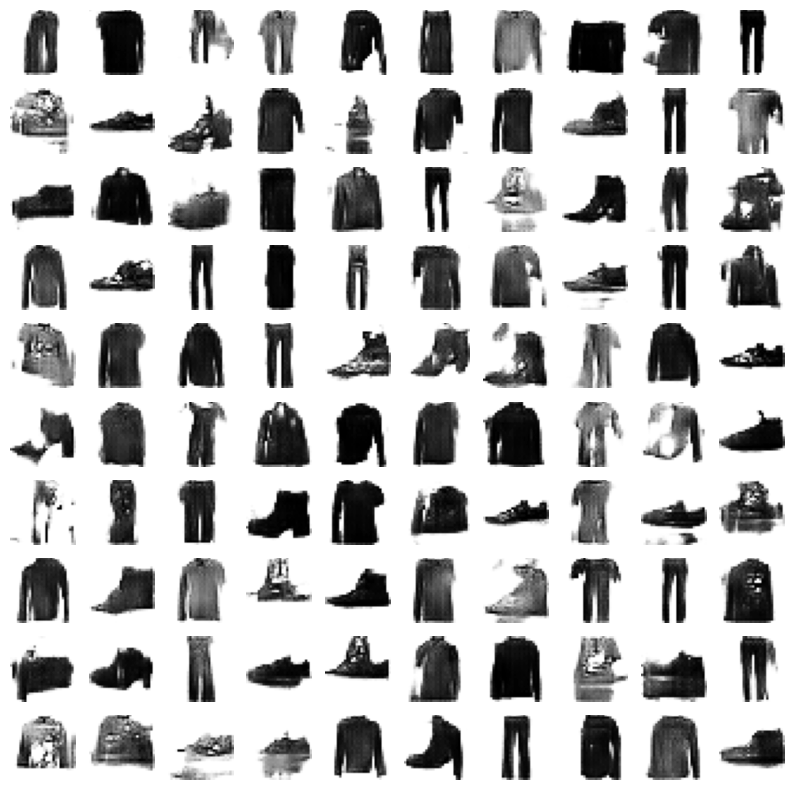

4/4 [==============================] - 0s 6ms/step
>Accuracy real: 6%, fake: 96%


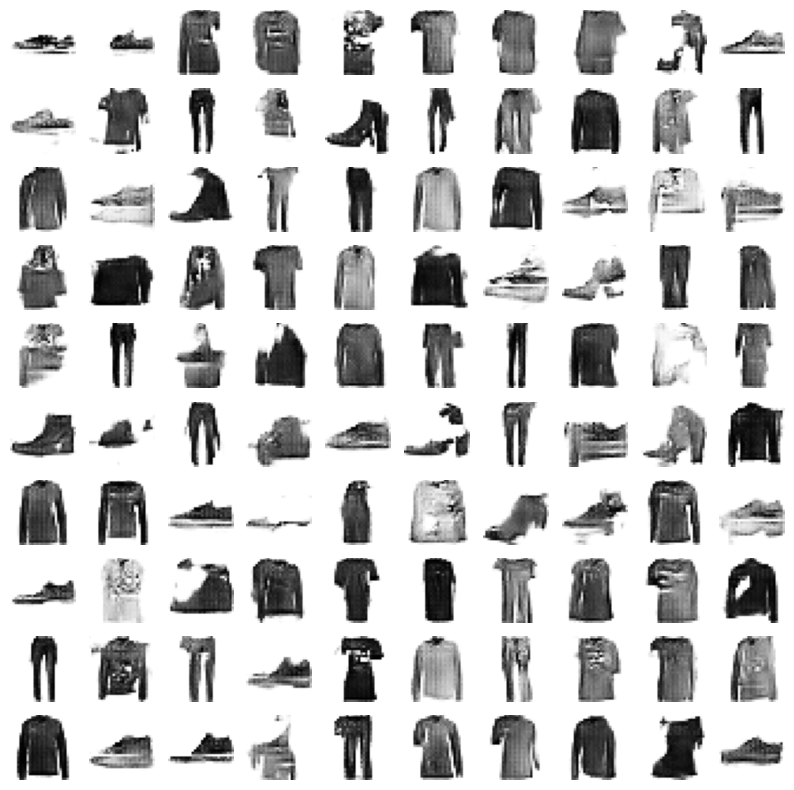

4/4 [==============================] - 0s 5ms/step
>Accuracy real: 1%, fake: 99%


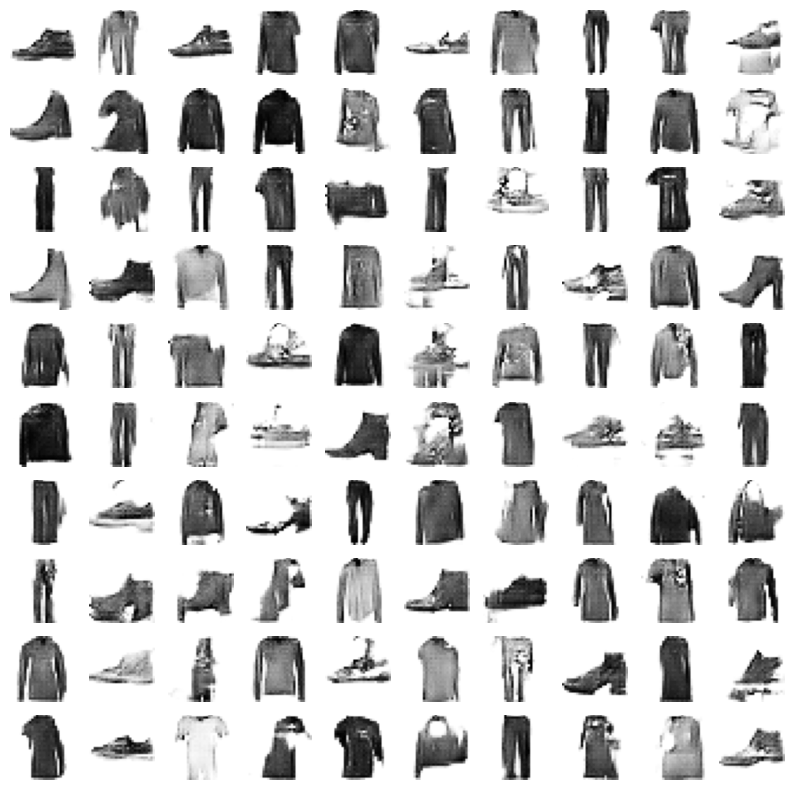

In [12]:
batch_size = 16
epochs = 10
bat_per_epo = int(dataset.shape[0] / batch_size)
half_batch = int(batch_size / 2)

for i in range(epochs):
  for j in range(bat_per_epo):
    X_real, y_real = generate_real_samples(dataset, half_batch)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
    X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
    d_loss, _ = discriminator.train_on_batch(X, y)
    X_gan = generate_latent_vector(latent_dim, batch_size)
    y_gan = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(X_gan, y_gan)
  summarize_performance(i, generator, discriminator, dataset, latent_dim)